Import Libraries

In [243]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis

import requests # library to handle requests
from bs4 import BeautifulSoup

import geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder # to get coordinates

import folium
from IPython.display import display

# import k-means from clustering stage
from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

Grab district-level data from website

In [244]:
url = requests.get('https://en.wikipedia.org/wiki/List_of_districts_of_Lima')
print(url.status_code) # A code of 200 means the page is indeed present

200


Use the Beautiful Soup library to find the data table that includes the info we need

In [245]:
src = url.content
soup = BeautifulSoup(src, 'lxml')
my_table = soup.find('table',{'class':'wikitable sortable'})

Extract the needed data elements from the data table

In [246]:
data_extract = []

for row in my_table.findAll('tr'):
    columns = row.find_all('td')
    columns = [element.text.strip() for element in columns]
    data_extract.append(columns)

Frame the data

In [247]:
df = pd.DataFrame(data_extract) # Convert the data from the list into a dataframe
df.head()

,0,1,2,3,4,5,6,7
0,None,None,None,None,None,None,None,None
1,Ancón,150102,299.22,"29,419",98.3,18741029 29 October 1874,02,
2,Ate,150103,77.72,"419,663","5,399.7",18570102 2 January 1857,03,
3,Barranco,150104,3.33,"45,922","13,790.4",18741026 26 October 1874,04,
4,Breña,150105,3.22,"94,808","29,443.5",19490715 15 July 1949,05,


Drop the first row and rest the index

In [248]:
df = df.drop([0]) # Drop the first row
df = df.reset_index(drop=True) # Reset the index so that it starts again from 0..1..2
df.head()

,0,1,2,3,4,5,6,7
0,Ancón,150102,299.22,"29,419",98.3,18741029 29 October 1874,02,
1,Ate,150103,77.72,"419,663","5,399.7",18570102 2 January 1857,03,
2,Barranco,150104,3.33,"45,922","13,790.4",18741026 26 October 1874,04,
3,Breña,150105,3.22,"94,808","29,443.5",19490715 15 July 1949,05,
4,Carabayllo,150106,346.88,"188,764",544.2,18210804 4 August 1821,06,


Drop the columns we don't need

In [249]:
df = df.drop([1, 2,3,4,5,6,7], axis = 1)

In [250]:
df.head()

,0
0,Ancón
1,Ate
2,Barranco
3,Breña
4,Carabayllo


Rename the column to "District" and add the suffix ", Lima" to distinguish district names from similar locations in other countires

In [251]:
df = df.rename(columns = {
    0: "District"
    })
df['District'] = df['District'] + ", " + "Lima"
df.head()

,District
0,"Ancón, Lima"
1,"Ate, Lima"
2,"Barranco, Lima"
3,"Breña, Lima"
4,"Carabayllo, Lima"


Reformat the name for "Santa Maria del Mar District, Lima" because the geocoder library can't find it. It can find the replacement value, however, "Santa Maria del Mar, Lima"

In [252]:
df['District'] = df['District'].replace(['Santa María del Mar District, Lima'],'Santa María del Mar, Lima')
df.head()

,District
0,"Ancón, Lima"
1,"Ate, Lima"
2,"Barranco, Lima"
3,"Breña, Lima"
4,"Carabayllo, Lima"


Activate the geopy service and create a list for latitude and longitude

In [253]:
service = geopy.Nominatim(user_agent = "myGeocoder")

In [254]:
lat = []
for District in df.District:
    lat.append(service.geocode(District).latitude)

In [255]:
long = []
for District in df.District:
    long.append(service.geocode(District).longitude) 

Convert the two new lists into a dataframe

In [256]:
geo = {'Latitude':lat,'Longitude':long}
df_geo = pd.DataFrame(geo)
df_geo.head()

,Latitude,Longitude
0,-11.696554,-77.111655
1,-12.038728,-76.896873
2,-12.143959,-77.020268
3,-12.059700,-77.050119
4,-11.794993,-76.989292


Join the new dataframe to the dataframe with the District names

In [257]:
df = pd.concat([df, df_geo], axis=1)
df.head()

,District,Latitude,Longitude
0,"Ancón, Lima",-11.696554,-77.111655
1,"Ate, Lima",-12.038728,-76.896873
2,"Barranco, Lima",-12.143959,-77.020268
3,"Breña, Lima",-12.059700,-77.050119
4,"Carabayllo, Lima",-11.794993,-76.989292


Grab the geocoordinate for Lima, Peru, to be used for out map

In [258]:
address = 'Lima, Peru'
geolocator = Nominatim(user_agent = "myGeocoder")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Lima, Peru are', latitude, ',' ,longitude)

The geograpical coordinate of Lima, Peru are -12.0621065 , -77.0365256


In [259]:
# create map of Lima using latitude and longitude values
map_lima = folium.Map(location=[latitude, longitude], zoom_start=13)

Use the folium library to map the districts in Lima

In [260]:
# add markers to map
for lat, lng, district in zip(df['Latitude'], df['Longitude'], df['District']):
  label = '{},{},{}'.format(district, lat, lng)
  label = folium.Popup(label, parse_html=True)
  folium.CircleMarker(
      [lat, lng],
      radius=5,
      popup=label,
      color='blue',
      fill=True,
      fill_color='#3186cc',
      fill_opacity=0.7).add_to(map_lima) 
    
display(map_lima)

Use your credentials to call the Foursquare API. We will use this to find all the venues nearby each district

In [261]:
# define Foursquare Credentials and Version
CLIENT_ID = 'Foursquare ID' # your Foursquare ID
CLIENT_SECRET = 'Foursquare Secret' # your Foursquare Secret
VERSION = '20180724' # Foursquare API version

Grab the top 100 venues that are within a radius of 2000 meters.

In [262]:
radius = 2000
LIMIT = 100

venues = []

for lat, long, district in zip(
                                                    df['Latitude'], 
                                                    df['Longitude'], 
                                                    df['District']
                                                ):
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)
        
    results = requests.get(url).json()['response']['groups'][0]['items']
    
    for venue in results:
        venues.append((
            district, 
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

Convert the venues list into a new DataFrame

In [263]:
venues_df = pd.DataFrame(venues)

Rename the columns

In [264]:
# define the column names
venues_df.columns = ['District', 
                     'DistrictLatitude', 
                     'DistructLongitude', 
                     'Venue', 
                     'VenueLongitude', 
                     'VenueLatitude', 
                     'VenueCategory']

print(venues_df.shape)
venues_df.head()

(2108, 7)


,District,DistrictLatitude,DistructLongitude,Venue,VenueLongitude,VenueLatitude,VenueCategory
0,"Ate, Lima",-12.038728,-76.896873,"Hotel Thunderbird ""El Pueblo""",-12.034299,-76.881955,Hotel
1,"Ate, Lima",-12.038728,-76.896873,La Granja Azul,-12.033249,-76.885768,Peruvian Restaurant
2,"Ate, Lima",-12.038728,-76.896873,Granja Azul Golf Club,-12.033012,-76.886601,Farm
3,"Ate, Lima",-12.038728,-76.896873,Toboganes Grill,-12.035640,-76.883482,Steakhouse
4,"Ate, Lima",-12.038728,-76.896873,Bar Marino,-12.036286,-76.881872,Seafood Restaurant


View the number of venues per district

In [265]:
venues_df.groupby(["District"]).count()

,DistrictLatitude,DistructLongitude,Venue,VenueLongitude,VenueLatitude,VenueCategory
District,,,,,,
"Ate, Lima",10,10,10,10,10,10
"Barranco, Lima",100,100,100,100,100,100
"Breña, Lima",100,100,100,100,100,100
"Carabayllo, Lima",2,2,2,2,2,2
"Chaclacayo, Lima",21,21,21,21,21,21
"Chorrillos, Lima",60,60,60,60,60,60
"Cieneguilla, Lima",10,10,10,10,10,10
"Comas, Lima",12,12,12,12,12,12
"El Agustino, Lima",25,25,25,25,25,25


In [266]:
print('There are {} uniques categories.'.format(len(venues_df['VenueCategory'].unique())))

There are 214 uniques categories.


In [267]:
venues_df['VenueCategory'].unique()

array(['Hotel', 'Peruvian Restaurant', 'Farm', 'Steakhouse',
       'Seafood Restaurant', 'Restaurant', 'Bar', 'Breakfast Spot',
       'BBQ Joint', 'Nightclub', 'Sandwich Place', 'Pizza Place',
       'Belgian Restaurant', 'Park', 'Coffee Shop', 'Café',
       'Organic Grocery', 'Art Gallery', 'Bookstore', 'Lounge', 'Bakery',
       'Ice Cream Shop', 'Spanish Restaurant', 'Scenic Lookout',
       'Gym / Fitness Center', 'Art Museum', 'Museum', 'Circus',
       'Hotel Bar', 'Deli / Bodega', 'Shopping Mall',
       'Performing Arts Venue', 'Market', 'Theater', 'Snack Place',
       'Cupcake Shop', 'Beach', 'Gym', 'Fried Chicken Joint',
       'Burger Joint', 'Trade School', 'Gourmet Shop', 'Comedy Club',
       'Public Art', 'Japanese Restaurant', 'Farmers Market', 'Trail',
       'Pet Store', 'Donut Shop', 'Chinese Restaurant', 'Soccer Field',
       'Tea Room', 'Dessert Shop', 'Movie Theater', 'High School',
       'Salon / Barbershop', 'Italian Restaurant', 'Pool',
       'Ramen Rest

View the top 10 venue categories

In [268]:
venues_df['CategoryCount'] = venues_df.groupby('VenueCategory')['VenueCategory'].transform('count')
venue_category_count = venues_df[['VenueCategory','CategoryCount']].sort_values(by='CategoryCount', ascending=False)
venue_category_count = venue_category_count.drop_duplicates()
venue_category_count[:10]

,VenueCategory,CategoryCount
585,Park,124
1821,Seafood Restaurant,123
376,Peruvian Restaurant,111
111,Restaurant,89
1492,Coffee Shop,71
1957,Café,60
629,Bakery,54
930,Hotel,50
1264,Fried Chicken Joint,50
146,Chinese Restaurant,49


Plot the top 10 venue categories

Text(0, 0.5, 'VenueCategory')

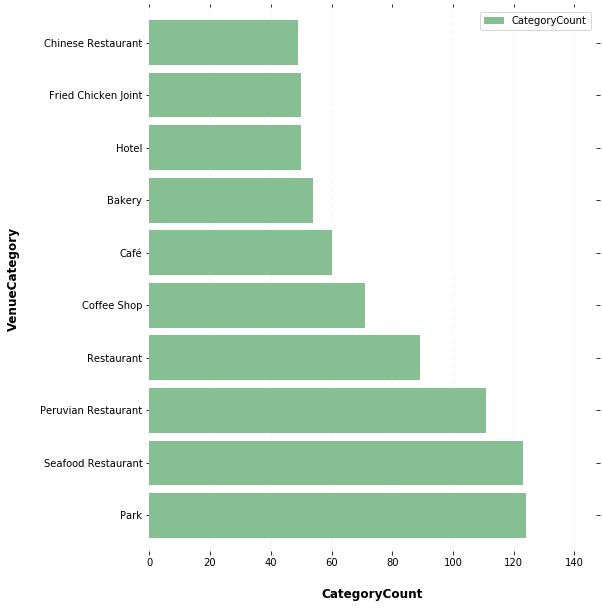

In [269]:
ax = venue_category_count[:10].plot.barh(x='VenueCategory', y='CategoryCount', figsize=(8, 10), color='#86bf91', zorder=2, width=0.85)

# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Switch off ticks
ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

# Draw vertical axis lines
vals = ax.get_xticks()
for tick in vals:
    ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

# Set x-axis label
ax.set_xlabel("CategoryCount", labelpad=20, weight='bold', size=12)

# Set y-axis label
ax.set_ylabel("VenueCategory", labelpad=20, weight='bold', size=12)

There aren't any Outdoors stores in the top 10 venue categories. The market may be untapped.

We will use the venue category "Athletics & Sports" to determine whether a district has a group of active people in the area. If so, then that is a potential market.

Fist step is to create a new data frame with the districts that already have a corporate presence in the marketplace

In [270]:
sports_df = venues_df[venues_df['VenueCategory'].isin(['Athletics & Sports'])]
sports_df

,District,DistrictLatitude,DistructLongitude,Venue,VenueLongitude,VenueLatitude,VenueCategory,CategoryCount
149,"Breña, Lima",-12.059700,-77.050119,Piscina Olimpica Campo De Marte,-12.070270,-77.042702,Athletics & Sports,13
649,"Lima, Lima",-12.062107,-77.036526,Piscina Olimpica Campo De Marte,-12.070270,-77.042702,Athletics & Sports,13
830,"Magdalena del Mar, Lima",-12.095654,-77.068213,Lima Cricket & Football Club,-12.098620,-77.061828,Athletics & Sports,13
868,"Magdalena del Mar, Lima",-12.095654,-77.068213,Malecón Costa Verde,-12.105011,-77.063954,Athletics & Sports,13
885,"Magdalena del Mar, Lima",-12.095654,-77.068213,El Golf de San Isidro,-12.099086,-77.051108,Athletics & Sports,13
1106,"Pueblo Libre, Lima",-12.076639,-77.067858,ReserClub,-12.077806,-77.078018,Athletics & Sports,13
1314,"San Borja, Lima",-12.096452,-76.995690,Pentagonito - Muévete San Borja,-12.100403,-76.988797,Athletics & Sports,13
1350,"San Borja, Lima",-12.096452,-76.995690,Circuito Pentagonito,-12.098885,-76.980668,Athletics & Sports,13
1381,"San Borja, Lima",-12.096452,-76.995690,Polideportivo Limatambo,-12.108564,-77.006843,Athletics & Sports,13
1495,"San Isidro, Lima",-12.097902,-77.035367,El Golf de San Isidro,-12.099086,-77.051108,Athletics & Sports,13


In [101]:
sports_df['SportsVenues'] = sports_df.groupby('District')['District'].transform('count')
district_sports_count = sports_df[['District','VenueCategory','SportsVenues']].sort_values(by='SportsVenues', ascending=False)
district_sports_count = district_sports_count.drop_duplicates()
district_sports_count

C:\Users\kansb\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,District,VenueCategory,SportsVenues
830,"Magdalena del Mar, Lima",Athletics & Sports,3
1314,"San Borja, Lima",Athletics & Sports,3
149,"Breña, Lima",Athletics & Sports,1
649,"Lima, Lima",Athletics & Sports,1
1106,"Pueblo Libre, Lima",Athletics & Sports,1
1495,"San Isidro, Lima",Athletics & Sports,1
1749,"San Miguel, Lima",Athletics & Sports,1
1942,"Santiago de Surco, Lima",Athletics & Sports,1
1989,"Surquillo, Lima",Athletics & Sports,1


Let's run a horizontal bar chart to locate the districts with the most active people. 

Text(0, 0.5, 'District')

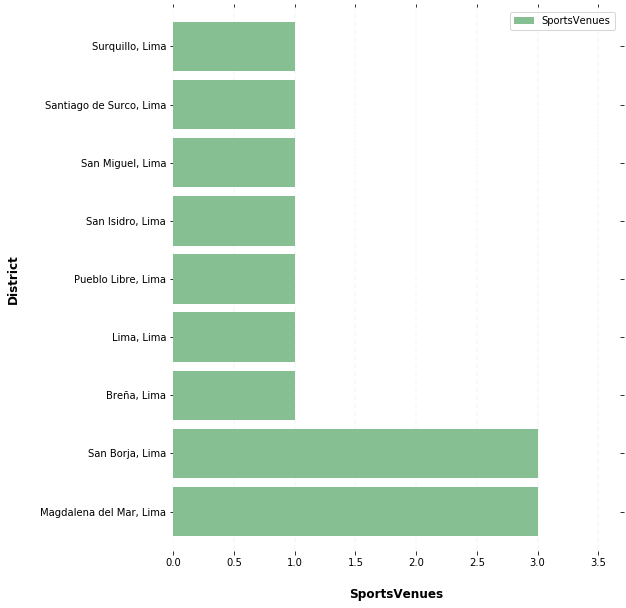

In [102]:
ax = district_sports_count.plot.barh(x='District', y='SportsVenues', figsize=(8, 10), color='#86bf91', zorder=2, width=0.85)

# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Switch off ticks
ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

# Draw vertical axis lines
vals = ax.get_xticks()
for tick in vals:
    ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

# Set x-axis label
ax.set_xlabel("SportsVenues", labelpad=20, weight='bold', size=12)

# Set y-axis label
ax.set_ylabel("District", labelpad=20, weight='bold', size=12)

### Analyze the districts

In [122]:
# one hot encoding
onehot_df = pd.get_dummies(venues_df[['VenueCategory']], prefix="", prefix_sep="")

# add district column back to dataframe
onehot_df['District'] = venues_df['District'] 

# move district column to the first column
fixed_columns = [onehot_df.columns[-1]] + list(onehot_df.columns[:-1])
onehot_df = onehot_df[fixed_columns]

print(onehot_df.shape)
onehot_df.head()

(2108, 215)


,District,Accessories Store,Airport,American Restaurant,Arcade,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,...,Trade School,Trail,Turkish Restaurant,Vegetarian / Vegan Restaurant,Veterinarian,Vietnamese Restaurant,Water Park,Wings Joint,Women's Store,Yoga Studio
0,"Ate, Lima",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Ate, Lima",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Ate, Lima",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Ate, Lima",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Ate, Lima",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Find the average frequencey of each venue, grouped by District

In [124]:
venue_avg = onehot_df.groupby(["District"]).mean().reset_index()

print(venue_avg.shape)
venue_avg.head()

(40, 215)


,District,Accessories Store,Airport,American Restaurant,Arcade,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,...,Trade School,Trail,Turkish Restaurant,Vegetarian / Vegan Restaurant,Veterinarian,Vietnamese Restaurant,Water Park,Wings Joint,Women's Store,Yoga Studio
0,"Ate, Lima",0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Barranco, Lima",0.0,0.0,0.00,0.0,0.0,0.01,0.01,0.0,0.0,...,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Breña, Lima",0.0,0.0,0.01,0.0,0.0,0.01,0.02,0.0,0.0,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"Carabayllo, Lima",0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Chaclacayo, Lima",0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


First, let's write a function to sort the venues in descending order.

In [162]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Let's create the new dataframe and display the top 10 venues for each neighborhood.

In [168]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

In [169]:
venue_avg.shape[0]

40

In [181]:
# create a new dataframe
district_venues_sorted = pd.DataFrame(columns=columns)
district_venues_sorted['District'] = venue_avg['District']

In [182]:
district_venues_sorted.head()

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Ate, Lima",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Barranco, Lima",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Breña, Lima",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Carabayllo, Lima",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"Chaclacayo, Lima",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [183]:
for ind in np.arange(venue_avg.shape[0]):
    district_venues_sorted.iloc[ind, 1:] = return_most_common_venues(venue_avg.iloc[ind, :], num_top_venues)

print(district_venues_sorted.shape)
district_venues_sorted.head()

(40, 11)


,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Ate, Lima",Restaurant,Peruvian Restaurant,Steakhouse,Seafood Restaurant,Bar,Farm,Breakfast Spot,BBQ Joint,Hotel,Dessert Shop
1,"Barranco, Lima",Peruvian Restaurant,Park,Restaurant,Hotel,Bakery,Bar,Coffee Shop,Gym / Fitness Center,Seafood Restaurant,Beach
2,"Breña, Lima",Peruvian Restaurant,Coffee Shop,Bar,Chinese Restaurant,Café,BBQ Joint,Restaurant,Park,Plaza,Bakery
3,"Carabayllo, Lima",Recreation Center,Chinese Restaurant,Yoga Studio,Electronics Store,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant
4,"Chaclacayo, Lima",Bakery,Park,Dessert Shop,Chinese Restaurant,Home Service,Pizza Place,Pool,Restaurant,Café,Snack Place


Run k-means to cluster the neighborhood into 5 clusters.

In [213]:
# set number of clusters
kclusters = 5

lima_grouped_clustering = venue_avg.drop('District', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(lima_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 2, 0, 0, 0, 0, 0, 0])

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [215]:
df_merged = df[1:]

df_merged = df_merged.join(district_venues_sorted.set_index('District'), on='District')

df_merged = df_merged.dropna()

In [220]:
df_merged = df_merged.astype({"Cluster Labels": int})
df_merged

,District,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"Ate, Lima",-12.038728,-76.896873,0,Restaurant,Peruvian Restaurant,Steakhouse,Seafood Restaurant,Bar,Farm,Breakfast Spot,BBQ Joint,Hotel,Dessert Shop
2,"Barranco, Lima",-12.143959,-77.020268,0,Peruvian Restaurant,Park,Restaurant,Hotel,Bakery,Bar,Coffee Shop,Gym / Fitness Center,Seafood Restaurant,Beach
3,"Breña, Lima",-12.059700,-77.050119,0,Peruvian Restaurant,Coffee Shop,Bar,Chinese Restaurant,Café,BBQ Joint,Restaurant,Park,Plaza,Bakery
4,"Carabayllo, Lima",-11.794993,-76.989292,2,Recreation Center,Chinese Restaurant,Yoga Studio,Electronics Store,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant
5,"Chaclacayo, Lima",-11.975740,-76.769871,0,Bakery,Park,Dessert Shop,Chinese Restaurant,Home Service,Pizza Place,Pool,Restaurant,Café,Snack Place
6,"Chorrillos, Lima",-12.192350,-77.008962,0,Fried Chicken Joint,Restaurant,Seafood Restaurant,Coffee Shop,Burger Joint,Supermarket,Sandwich Place,Clothing Store,Bakery,Shopping Mall
7,"Cieneguilla, Lima",-12.073167,-76.777071,0,Hotel,Playground,BBQ Joint,Ice Cream Shop,Restaurant,Resort,South American Restaurant,Cupcake Shop,Electronics Store,Flea Market
8,"Comas, Lima",-11.932861,-77.040674,0,Multiplex,Restaurant,Grocery Store,Mexican Restaurant,Asian Restaurant,Food & Drink Shop,Seafood Restaurant,Chinese Restaurant,Department Store,Diner
9,"El Agustino, Lima",-12.042052,-76.995714,0,Fried Chicken Joint,Peruvian Restaurant,Restaurant,Cemetery,Seafood Restaurant,Bus Station,Platform,Dessert Shop,Nightclub,Multiplex
10,"Independencia, Lima",-11.989307,-77.047331,0,Peruvian Restaurant,Bus Station,Nightclub,Restaurant,Sporting Goods Shop,Shopping Mall,Sandwich Place,Ice Cream Shop,Fried Chicken Joint,Electronics Store


Visualize the clusters

In [217]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

In [218]:
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_merged['Latitude'], df_merged['Longitude'], df_merged['District'], df_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [225]:
df_merged.loc[df_merged['Cluster Labels'] == 0]

,District,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"Ate, Lima",-12.038728,-76.896873,0,Restaurant,Peruvian Restaurant,Steakhouse,Seafood Restaurant,Bar,Farm,Breakfast Spot,BBQ Joint,Hotel,Dessert Shop
2,"Barranco, Lima",-12.143959,-77.020268,0,Peruvian Restaurant,Park,Restaurant,Hotel,Bakery,Bar,Coffee Shop,Gym / Fitness Center,Seafood Restaurant,Beach
3,"Breña, Lima",-12.059700,-77.050119,0,Peruvian Restaurant,Coffee Shop,Bar,Chinese Restaurant,Café,BBQ Joint,Restaurant,Park,Plaza,Bakery
5,"Chaclacayo, Lima",-11.975740,-76.769871,0,Bakery,Park,Dessert Shop,Chinese Restaurant,Home Service,Pizza Place,Pool,Restaurant,Café,Snack Place
6,"Chorrillos, Lima",-12.192350,-77.008962,0,Fried Chicken Joint,Restaurant,Seafood Restaurant,Coffee Shop,Burger Joint,Supermarket,Sandwich Place,Clothing Store,Bakery,Shopping Mall
7,"Cieneguilla, Lima",-12.073167,-76.777071,0,Hotel,Playground,BBQ Joint,Ice Cream Shop,Restaurant,Resort,South American Restaurant,Cupcake Shop,Electronics Store,Flea Market
8,"Comas, Lima",-11.932861,-77.040674,0,Multiplex,Restaurant,Grocery Store,Mexican Restaurant,Asian Restaurant,Food & Drink Shop,Seafood Restaurant,Chinese Restaurant,Department Store,Diner
9,"El Agustino, Lima",-12.042052,-76.995714,0,Fried Chicken Joint,Peruvian Restaurant,Restaurant,Cemetery,Seafood Restaurant,Bus Station,Platform,Dessert Shop,Nightclub,Multiplex
10,"Independencia, Lima",-11.989307,-77.047331,0,Peruvian Restaurant,Bus Station,Nightclub,Restaurant,Sporting Goods Shop,Shopping Mall,Sandwich Place,Ice Cream Shop,Fried Chicken Joint,Electronics Store
11,"Jesús María, Lima",-12.078186,-77.046412,0,Peruvian Restaurant,Italian Restaurant,Café,Bakery,Theater,Japanese Restaurant,Sushi Restaurant,Convenience Store,Coffee Shop,Latin American Restaurant


In [230]:
df_merged.loc[df_merged['Cluster Labels'] == 1]

,District,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,"Pucusana, Lima",-12.482092,-76.797453,1,Beach,Italian Restaurant,Harbor / Marina,Yoga Studio,Electronics Store,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop,Field


In [231]:
df_merged.loc[df_merged['Cluster Labels'] == 2]

,District,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,"Carabayllo, Lima",-11.794993,-76.989292,2,Recreation Center,Chinese Restaurant,Yoga Studio,Electronics Store,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant


In [234]:
cluster_3 = df_merged.loc[df_merged['Cluster Labels'] == 3]
cluster_3 = cluster_3.drop(['Latitude','Longitude'], axis = 1)
cluster_3

,District,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
25,"Punta Hermosa, Lima",3,Seafood Restaurant,Beach,Nightclub,Pizza Place,Restaurant,Italian Restaurant,BBQ Joint,Convenience Store,Café,Farmers Market
26,"Punta Negra, Lima",3,Beach,Nightclub,Fried Chicken Joint,Other Great Outdoors,Restaurant,Toll Plaza,Donut Shop,Fish Market,Fish & Chips Shop,Field
28,"San Bartolo, Lima",3,Beach,Seafood Restaurant,Surf Spot,Restaurant,Italian Restaurant,Hotel,Nightclub,Market,Ice Cream Shop,Motorcycle Shop
37,"Santa María del Mar, Lima",3,Seafood Restaurant,Beach,Italian Restaurant,Nightclub,Restaurant,Pizza Place,Surf Spot,Scenic Lookout,Scandinavian Restaurant,Market


In [233]:
df_merged.loc[df_merged['Cluster Labels'] == 4]

,District,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
36,"Santa Anita, Lima",-12.223383,-76.847707,4,Peruvian Restaurant,Diner,Plaza,Italian Restaurant,City,Restaurant,Donut Shop,Fish Market,Fish & Chips Shop,Field


Now that we've clustered our districts, let's identify districts that already have a presence of Outdoors Stores. We'll use "Sporting Goods Shop" as our proxy

In [272]:
competition_df = venues_df[venues_df['VenueCategory'].isin(['Sporting Goods Shop'])]
competition_df

,District,DistrictLatitude,DistructLongitude,Venue,VenueLongitude,VenueLatitude,VenueCategory,CategoryCount
350,"Independencia, Lima",-11.989307,-77.047331,adidas,-11.993821,-77.062178,Sporting Goods Shop,3
356,"Independencia, Lima",-11.989307,-77.047331,Marathon Sports,-11.993742,-77.061833,Sporting Goods Shop,3
1572,"San Juan de Miraflores, Lima",-12.155852,-76.972129,Area de Deportes - Saga Atocongo,-12.145492,-76.981388,Sporting Goods Shop,3


In [273]:
competition_df['SportingGoodsShops'] = competition_df.groupby('District')['District'].transform('count')
competition_count = competition_df[['District','VenueCategory','SportingGoodsShops']].sort_values(by='SportingGoodsShops', ascending=False)
competition_count = competition_count.drop_duplicates()
competition_count

C:\Users\kansb\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,District,VenueCategory,SportingGoodsShops
350,"Independencia, Lima",Sporting Goods Shop,2
1572,"San Juan de Miraflores, Lima",Sporting Goods Shop,1


Text(0, 0.5, 'District')

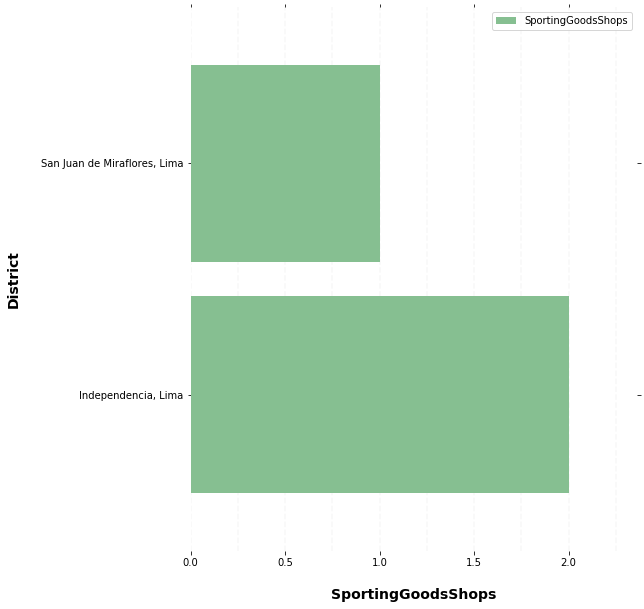

In [277]:
ax = competition_count.plot.barh(x='District', y='SportingGoodsShops', figsize=(8, 10), color='#86bf91', zorder=2, width=0.85)

# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Switch off ticks
ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

# Draw vertical axis lines
vals = ax.get_xticks()
for tick in vals:
    ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

# Set x-axis label
ax.set_xlabel("SportingGoodsShops", labelpad=20, weight='bold', size=14)

# Set y-axis label
ax.set_ylabel("District", labelpad=20, weight='bold', size=14)